In [ ]:
£#Standard DataFrame packages
import numpy as np 
import pandas as pd 

#Process and model pacakges
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from pycaret.classification import *


#Visualization packages
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns

#Do we need to prevent warnings to be displayed?
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
df = files.upload()
df_test = files.upload()

Saving Project2_Train.csv to Project2_Train.csv


Saving Project2_Test.csv to Project2_Test.csv


In [ ]:
#Read in files
df = pd.read_csv("Project2_Train.csv")
df_test = pd.read_csv("Project2_Test.csv")

In [ ]:
#Remove id columns, as it is not a feature column
df = df.iloc[:,1:]
df_test = df_test.iloc[:,1:]

In [ ]:
#Show data type inference using pycaret
types = setup(df, target = 'Response')

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:06:52
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Gender,Categorical
Age,Numeric
Region_Code,Categorical
Vehicle_Age,Categorical
Vehicle_Damage,Categorical
Annual_Premium,Numeric
Vintage,Numeric
Response,Label


AttributeError: ignored

# Functions

In [ ]:
def plotROC(fpr,tpr, roc_auc):
    """
    This function plots the ROC curve which in simple terms compares
    the performance of our model to a random guess

    params:
      fpr: numpy.array
      tpr: numpy.array

    :return:
      ROC curve: matplotlib.pyplot
    """

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [ ]:

def data_preprocess(data,type):
    """
    This function is used to prepare the data to be runable 
    for the models. We have three types of data in the dataframe.
    Continous, which is Annual_Premium & Vintage, Nominal categorical variables
    which is Gender, Region_Code, Vehicle_Damage and Ordinal Categorical variables
    which is vehicle age. Here we also differentiate between trees and logistic regression,
    as the tree structure requires us to do integer encoding for the vehicle age.

    params:
      data: pd.DataFrame
      type: str

    :return:
      X_train: pd.DataFrame
      y_train: pd.DataFrame
    """

    data = data.copy()
    
    if type == "trees":
        le = LabelEncoder()
        
        # Integer Encoding
        data["Vehicle_Age"] = le.fit_transform(data["Vehicle_Age"]) # 1-2 year = 0, < 1 year = 1, > 2 year = 2

        # Dummy Encoding 
        # Vehicle_Age - VA, Region_Code - RC, Vehicle_Damage - VD
        data = pd.get_dummies(data,columns=["Region_Code","Gender","Vehicle_Damage"], 
                                prefix=["RC","Gender","VD"], drop_first=True)

        # Split into train 
        y_train = data.loc[:, 'Response']
        X_train = data.drop('Response', 1)

        return X_train, y_train

    elif type == "LogReg":
        # Dummy Encoding 
        # Vehicle_Age - VA, Region_Code - RC, Vehicle_Damage - VD
        data = pd.get_dummies(data,columns=["Vehicle_Age","Region_Code","Gender","Vehicle_Damage"], 
                                        prefix=["VA","RC","Gender","VD"])

        data = data.rename(columns={"VA_1-2 Year": "VA_1-2", "VA_< 1 Year": "VA<1", "VA_> 2 Years": "VA>2"})

        # Drop dummy columns to avoid collinearity
        data = data.drop(columns=['VA<1', 'RC_3', 'Gender_Female', 'VD_No'])

        # Split into train
        y_train = data.loc[:, 'Response']
        X_train = data.drop('Response', 1)

        return X_train, y_train

# Classification Tree

In [ ]:
# Preprocess Data for CT 
X_train = data_preprocess(df, "trees")[0]
y_train = data_preprocess(df, "trees")[1]

X_test = data_preprocess(df_test, "trees")[0]
y_test = data_preprocess(df_test, "trees")[1]

In [ ]:
# Training Set 

# Create a DT Classifier with specified criterion
clf = DecisionTreeClassifier(random_state=1)

# Create the parameter grid to allow GridSearchCV to selevt the optimal parameters for prediction
param_grid = {"max_depth": [1,2,3], 
                "min_samples_leaf": [2,5,10,20]} 

# Create a GridSearchCV object
grid_clf_class = GridSearchCV(estimator=clf,
                            param_grid=param_grid,
                            scoring="roc_auc",
                            cv=5,
                            refit=True,
                            return_train_score=True)

# Create model 
clf_result = grid_clf_class.fit(X_train, y_train)

# Checking of GridSearch results 
result = pd.DataFrame(clf_result.cv_results_)
result = result[result["rank_test_score"] == 1][["mean_test_score","mean_train_score"]]

mean_test_score = result.values[0][0]
mean_train_score = result.values[0][1]

print("mean_test_score:", round(mean_test_score,3))
print("mean_train_score:", round(mean_train_score,3))

mean_test_score: 0.816
mean_train_score: 0.821


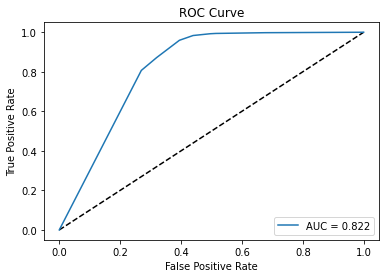

Best Parameters for Classification Tree: {'max_depth': 3, 'min_samples_leaf': 20}
Train ROC-AUC Score for Classification Tree: 0.822


In [ ]:
# Evaluate probabilities based on training set, as we are not making a prediction yet, but merely choosing the best model
best_params = clf_result.best_params_
predictions_proba = grid_clf_class.best_estimator_.predict_proba(X_train)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_train, predictions_proba)
auroc_dt_train = roc_auc_score(y_train, predictions_proba)

plotROC(fpr,tpr, auroc_dt_train)

print("Best Parameters for Classification Tree:",best_params)
print("Train ROC-AUC Score for Classification Tree:", round(auroc_dt_train,3))

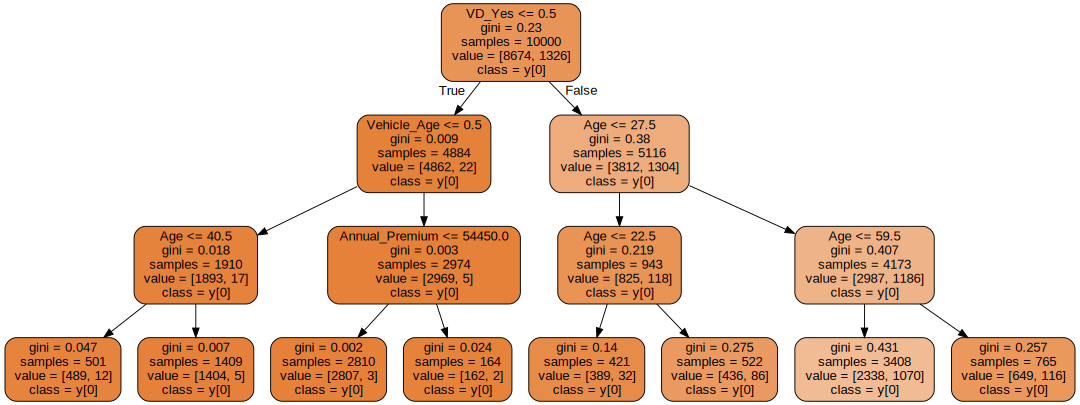

In [ ]:
feature_names = X_train.columns
dot_data = export_graphviz(grid_clf_class.best_estimator_, out_file=None, 
            filled=True, rounded=True, feature_names=feature_names, class_names=True)

# Decision Tree
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"15,15!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())

gvz_graph

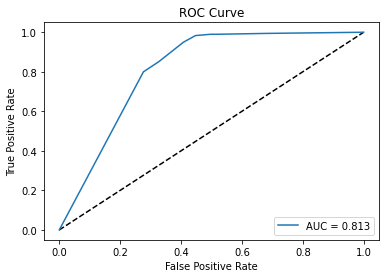

Test ROC-AUC Score for Classification Tree: 0.813


In [ ]:
# Test Set 
predictions_proba = grid_clf_class.best_estimator_.predict_proba(X_test)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
auroc_dt_test = roc_auc_score(y_test, predictions_proba)

plotROC(fpr,tpr, auroc_dt_test)

print("Test ROC-AUC Score for Classification Tree:", round(auroc_dt_test,3))

# Logistic Regression

In [ ]:
# Preprocess Data for LogReg
X_train = data_preprocess(df, "LogReg")[0]
y_train = data_preprocess(df, "LogReg")[1]

X_test = data_preprocess(df_test, "LogReg")[0]
y_test = data_preprocess(df_test, "LogReg")[1]

In [ ]:
# Training Set 

# Create a LR with specified criterion
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions 
lr = LogisticRegression(random_state=1, penalty= "l1", solver="liblinear")

# Create the parameter grid
param_grid = {'C':[0.001, 0.01, 0.05, 0.1]} 

# Create a GridSearchCV object
grid_lr_class = GridSearchCV(estimator=lr,
                            param_grid=param_grid,
                            scoring="roc_auc",
                            cv=5,
                            refit=True,
                            return_train_score=True)

# Create model 
lr_result = grid_lr_class.fit(X_train, y_train)

# Checking of GridSearch results 
result = pd.DataFrame(lr_result.cv_results_)
result = result[result["rank_test_score"] == 1][["mean_test_score","mean_train_score"]]

mean_test_score = result.values[0][0]
mean_train_score = result.values[0][1]

print("mean_test_score:", round(mean_test_score,3))
print("mean_train_score:", round(mean_train_score,3))

mean_test_score: 0.817
mean_train_score: 0.821


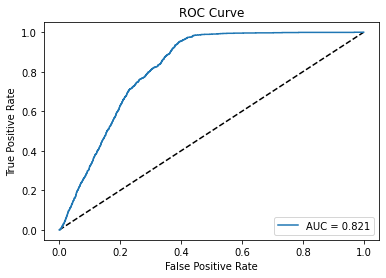

In [ ]:
# Evaluate model 
best_params = lr_result.best_params_
predictions_proba = grid_lr_class.best_estimator_.predict_proba(X_train)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_train, predictions_proba)
auroc_lr_train = roc_auc_score(y_train, predictions_proba)

plotROC(fpr,tpr, auroc_lr_train)

In [ ]:
feature_names = X_train.columns
coef = grid_lr_class.best_estimator_.coef_[0]
summary = pd.DataFrame({"Features" : feature_names, "Coefficient": coef})

print("Best Parameters for Logistic regression:",best_params)
print("Train ROC-AUC Score for Logistic regression:", round(auroc_lr_train,3))
summary

Best Parameters for Logistic regression: {'C': 0.1}
Train ROC-AUC Score for Logistic regression: 0.821


,Features,Coefficient
0,Age,-0.020283
1,Annual_Premium,-0.000002
2,Vintage,-0.000505
3,VA_1-2,0.901402
4,VA>2,1.050778
5,RC_8,-0.190837
6,RC_11,0.064158
7,RC_15,-0.458777
8,RC_28,0.000000
9,RC_29,0.000000


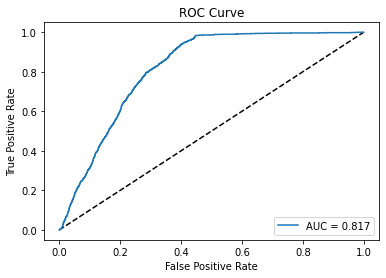

In [ ]:
predictions_proba = grid_lr_class.best_estimator_.predict_proba(X_test)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
auroc_lr_test = roc_auc_score(y_test, predictions_proba)

plotROC(fpr,tpr, auroc_lr_test)

In [ ]:
feature_names = X_test.columns
coef = grid_lr_class.best_estimator_.coef_[0]
summary = pd.DataFrame({"Features" : feature_names, "Coefficient": coef})

print("Test ROC-AUC Score for Logistic regression:", round(auroc_lr_test,3))
summary

Test ROC-AUC Score for Logistic regression: 0.817


,Features,Coefficient
0,Age,-0.020283
1,Annual_Premium,-0.000002
2,Vintage,-0.000505
3,VA_1-2,0.901402
4,VA>2,1.050778
5,RC_8,-0.190837
6,RC_11,0.064158
7,RC_15,-0.458777
8,RC_28,0.000000
9,RC_29,0.000000


In [ ]:
summary['Coefficient'] = round(summary['Coefficient'],2)
data_t = summary.T
data_t.columns = data_t.iloc[0]
data_t = data_t.iloc[1:2]
data_t

Features,Age,Annual_Premium,Vintage,VA_1-2,VA>2,RC_8,RC_11,RC_15,RC_28,RC_29,RC_30,RC_41,RC_46,RC_50,Gender_Male,VD_Yes
Coefficient,-0.02,-0,-0,0.9,1.05,-0.19,0.06,-0.46,0,0,0,0,-0.38,0,0.01,3.17


# Random Forest

In [ ]:
# Preprocess Data for Random Forest
X_train = data_preprocess(df, "trees")[0]
y_train = data_preprocess(df, "trees")[1]

X_test = data_preprocess(df_test, "trees")[0]
y_test = data_preprocess(df_test, "trees")[1]

In [ ]:
# Training Set 

# Create a rf with specified criterion
rf = RandomForestClassifier(random_state=1)

# Create the parameter grid
param_grid = {"max_depth": [2,3,4,5], 
                "min_samples_leaf": [5,10,25,50], 
                "n_estimators": np.arange(100,500,100)} 

# Create a GridSearchCV object
grid_rf_class = GridSearchCV(estimator=rf,
                            param_grid=param_grid,
                            scoring="roc_auc",
                            cv=5,
                            refit=True, n_jobs= 2,
                            return_train_score=True)

# Create model 
rf_result = grid_rf_class.fit(X_train, y_train)

# Checking of GridSearch results 
result = pd.DataFrame(rf_result.cv_results_)
result = result[result["rank_test_score"] == 1][["mean_test_score","mean_train_score"]]

mean_test_score = result.values[0][0]
mean_train_score = result.values[0][1]

print("mean_test_score:", round(mean_test_score,3))
print("mean_train_score:", round(mean_train_score,3))

mean_test_score: 0.823
mean_train_score: 0.854


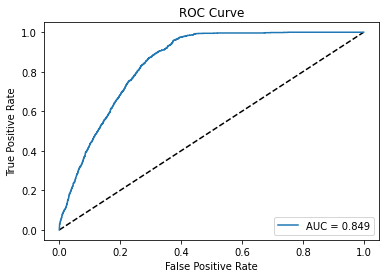

Best Parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 300}
Train ROC-AUC Score for Random Forest: 0.849


In [ ]:
# Evaluate model 
best_params = rf_result.best_params_
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_train)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_train, predictions_proba)
auroc_rf_train = roc_auc_score(y_train, predictions_proba)

plotROC(fpr,tpr, auroc_rf_train)

print("Best Parameters for Random Forest:",best_params)
print("Train ROC-AUC Score for Random Forest:", round(auroc_rf_train,3))

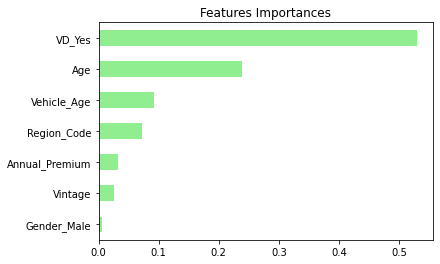

In [ ]:
# Create a pd.Series of features importances
importances = pd.Series(data=grid_rf_class.best_estimator_.feature_importances_,
                        index= X_train.columns)

# Sort importances
Region_Code_val = sum(importances.loc[[col for col in X_train.columns if "RC_" in col]])
importances = importances.loc[[col for col in X_train.columns if "RC_" not in col]]
importances.loc["Region_Code"] = Region_Code_val
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(color='lightgreen', kind='barh')
plt.title('Features Importances')

plt.show()

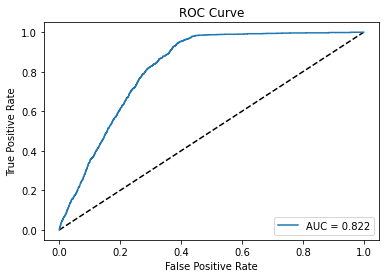

Test ROC-AUC Score for Random Forest: 0.822


In [ ]:
# Test Set 
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_test)[:,1]

# Compute fpr & tpr
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
auroc_rf_test = roc_auc_score(y_test, predictions_proba)

plotROC(fpr,tpr,auroc_rf_test)

print("Test ROC-AUC Score for Random Forest:", round(auroc_rf_test,3))

In [ ]:
# Preprocess Data for CT & RF
X_train = data_preprocess(df, "trees")[0]
y_train = data_preprocess(df, "trees")[1]

X_test = data_preprocess(df_test, "trees")[0]
y_test = data_preprocess(df_test, "trees")[1]

predictions_proba_clf = grid_clf_class.best_estimator_.predict_proba(X_train)[:,1]
predictions_proba_rf = grid_rf_class.best_estimator_.predict_proba(X_train)[:,1]

# Preprocess Data for LR
X_train = data_preprocess(df, "LogReg")[0]
y_train = data_preprocess(df, "LogReg")[1]

X_test = data_preprocess(df_test, "LogReg")[0]
y_test = data_preprocess(df_test, "LogReg")[1]

predictions_proba_lr = grid_lr_class.best_estimator_.predict_proba(X_train)[:,1]

In [ ]:
# Compute fpr & tpr
fpr_clf, tpr_clf, _ = roc_curve(y_train, predictions_proba_clf)
auroc_dt_train = roc_auc_score(y_train, predictions_proba_clf)

fpr_lr, tpr_lr, _ = roc_curve(y_train, predictions_proba_lr)
auroc_lr_train = roc_auc_score(y_train, predictions_proba_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_train, predictions_proba_rf)
auroc_rf_train = roc_auc_score(y_train, predictions_proba_rf)

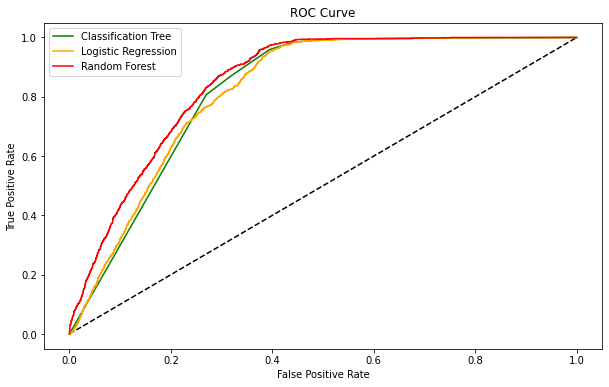

,models,train results (Validation),test results
0,Classification Tree,0.822,0.813
1,Logistic Regression,0.821,0.817
2,Random Forest,0.849,0.822


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_clf, tpr_clf, label='Classification Tree', color = "green")
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression', color = "orange")
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color = "red")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend()
plt.show()

consolidate = pd.DataFrame({'models': ["Classification Tree", "Logistic Regression", "Random Forest"],
             'train results (Validation)': [round(auroc_dt_train,3), round(auroc_lr_train,3), round(auroc_rf_train,3)],
             "test results": [round(auroc_dt_test,3), round(auroc_lr_test,3), round(auroc_rf_test,3)]})
consolidate

In [ ]:
data = consolidate.T
data.columns = data.iloc[0]
data = data.iloc[1:2]
data

models,Classification Tree,Logistic Regression,Random Forest
train results,0.822,0.821,0.849


# Chosen Model: Random Forest

In [ ]:
# Types of models: (1) grid_clf_class, (2) grid_lr_class, (3) grid_rf_class

In [ ]:
# Preprocess Data for Random Forest
# Use training set to determine the benefit schemes
X_train = data_preprocess(df, "trees")[0]
y_train = data_preprocess(df, "trees")[1]

In [ ]:
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_train)[:,1]
probability_threshold = [0.01, 0.1, 0.2, 0.5]
cm = []

for threshold in probability_threshold:
    pred = (predictions_proba >= threshold).astype('int')
    cm.append(confusion_matrix(y_train, pred))

In [ ]:
def compute_benefit(cm): 
    probability_threshold = [0.01, 0.1, 0.2, 0.5]
    
    for num in range(4):
        tn, fp, fn, tp = cm[num].ravel()
        benefit_structure = tp*10 + fn*(-10) + fp*(-2) + (tp+fp)*(-1)
        print("Benefit Structure for", probability_threshold[num],"is", benefit_structure)

    for num in range(4):
        tn, fp, fn, tp = cm[num].ravel()
        benefit_structure = tp*100 + fn*(-100) + fp*(-2) + (tp+fp)*(-1)
        print("New Benefit Structure for", probability_threshold[num],"is", benefit_structure)

In [ ]:
# Old Benefit Structure 
bs = []
for num in range(4):
    probability_threshold = [0.01, 0.1, 0.2, 0.5]
    tn, fp, fn, tp = cm[num].ravel()
    benefit_structure = tp*10 + fn*(-10) + fp*(-2) + (tp+fp)*(-1)
    bs.append(benefit_structure)
    
outcome = pd.DataFrame({"threshold":probability_threshold, "benefit": bs})
outcome

,threshold,benefit
0,0.01,-13899
1,0.10,840
2,0.20,963
3,0.50,-13260


In [ ]:
# New Benefit Structure 
bs = []
for num in range(4):
    probability_threshold = [0.01, 0.1, 0.2, 0.5]
    tn, fp, fn, tp = cm[num].ravel()
    benefit_structure = tp*100 + fn*(-100) + fp*(-2) + (tp+fp)*(-1)
    bs.append(benefit_structure)
outcome = pd.DataFrame({"threshold":probability_threshold, "benefit": bs})
outcome

,threshold,benefit
0,0.01,105441
1,0.10,114780
2,0.20,91683
3,0.50,-132600
